# Assignment - Syntactic Analysis

## Problem Statement

In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

   - Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
   - Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

## Data

For this assignment, you’ll use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK(https://www.nltk.org/_modules/nltk/tag/mapping.html) comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

Note that using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

 

## Goals

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 

You need to accomplish the following in this assignment:

 - Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
 - Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
 - Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
 - List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## POS tagging using modified Viterbi

### Data Preparation

In [1]:
### Importing libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [2]:
### Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
### First three sentences in te dataset
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
### Point the random seed as starting random value so that we can use in future.
random.seed(1000)

### Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

### Get the length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


/home/ash/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
### Fetching list of tagged words within training data set
train_tagged_words = [tup for sent in train_set for tup in sent]

### Fetch the length of the total tagged words within training data set
len(train_tagged_words)

95708

In [6]:
### Visualize the first 10 tokens/words in the training data set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Meanwhile', ',', 'the', 'bad', 'bank', 'with', 'the', 'junk', 'bonds', '--']

In [7]:
### Fetching the total unique words within the training data set
V_unique = set(tokens)
print(len(V_unique))

12097


In [8]:
### Number of pos tags in the training corpus
T_number = set([pair[1] for pair in train_tagged_words])
print(len(T_number))
print(T_number)

12
{'ADJ', 'VERB', 'X', 'PRT', 'PRON', 'NUM', 'ADV', '.', 'ADP', 'CONJ', 'NOUN', 'DET'}


As expected there are only 12 tags which are part of universal tagset

### Build the vanilla Viterbi based POS tagger

In [9]:
### Creating numpy array of no of pos tags by total vocabulary
t = len(T_number)
v = len(V_unique)
w_given_t = np.zeros((t, v))

In [10]:
### Function to compute word given tag: *Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
### Function to compute tag given tag: tag2(t2) given tag1 (t1), i.e. *Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
### Creating t x t (pos tags x pos tags) transition matrix of same tag
### each column is t2, each row is t1
### thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T_number), len(T_number)), dtype='float32')
for i, t1 in enumerate(list(T_number)):
    for j, t2 in enumerate(list(T_number)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
### Converting the matrix to a df for better readability.
tags_df = pd.DataFrame(tags_matrix, columns = list(T_number), index=list(T_number))
tags_df

,ADJ,VERB,X,PRT,PRON,NUM,ADV,.,ADP,CONJ,NOUN,DET
ADJ,0.066260,0.011867,0.021592,0.011208,0.000659,0.020933,0.004780,0.063623,0.077468,0.016318,0.700511,0.004780
VERB,0.064846,0.170084,0.217287,0.031726,0.035441,0.022054,0.081947,0.035131,0.090768,0.005417,0.110578,0.134721
X,0.017362,0.203727,0.074227,0.184294,0.056547,0.002389,0.026282,0.163906,0.143995,0.010354,0.061962,0.054954
PRT,0.083360,0.399218,0.013676,0.001954,0.016933,0.055031,0.009769,0.042331,0.020840,0.002279,0.250733,0.103875
PRON,0.072636,0.487702,0.091852,0.012298,0.007686,0.007302,0.033051,0.041122,0.022291,0.004996,0.209454,0.009608
NUM,0.033893,0.016797,0.209958,0.026695,0.001500,0.184463,0.002999,0.117277,0.035393,0.013497,0.354529,0.002999
ADV,0.127737,0.345388,0.023889,0.012940,0.014930,0.031851,0.078633,0.136032,0.120106,0.007299,0.031188,0.070007
.,0.043502,0.088084,0.027110,0.002522,0.065658,0.081059,0.051968,0.092948,0.091327,0.056922,0.223903,0.174908
ADP,0.106501,0.008340,0.034645,0.001497,0.069504,0.061912,0.013259,0.039136,0.017002,0.000855,0.321322,0.326027
CONJ,0.115295,0.158996,0.007903,0.004649,0.059042,0.040446,0.055323,0.033938,0.053464,0.000465,0.351929,0.118550


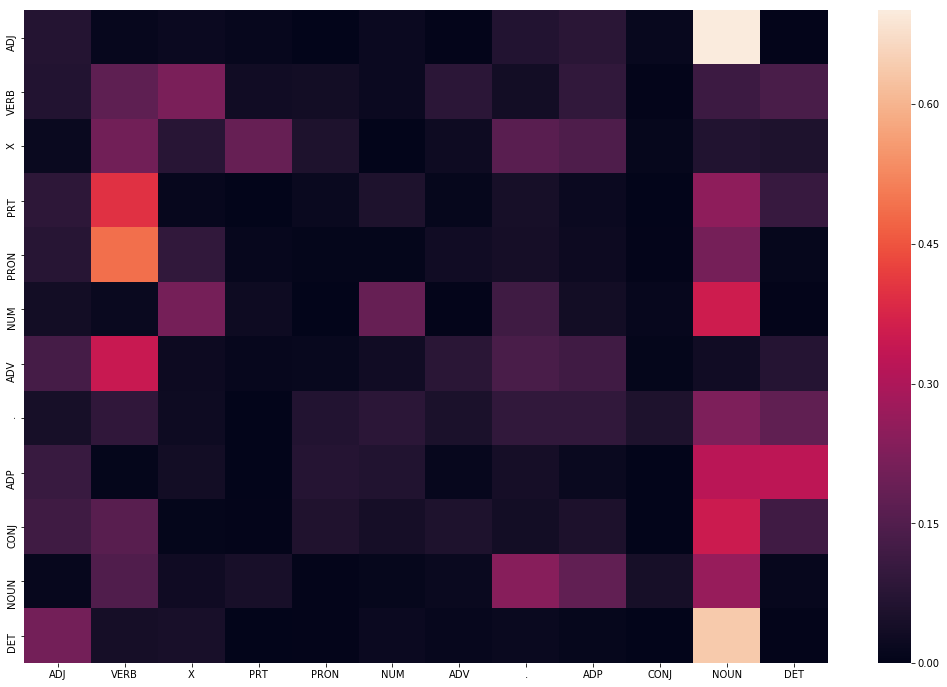

In [14]:
### Visualization of heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

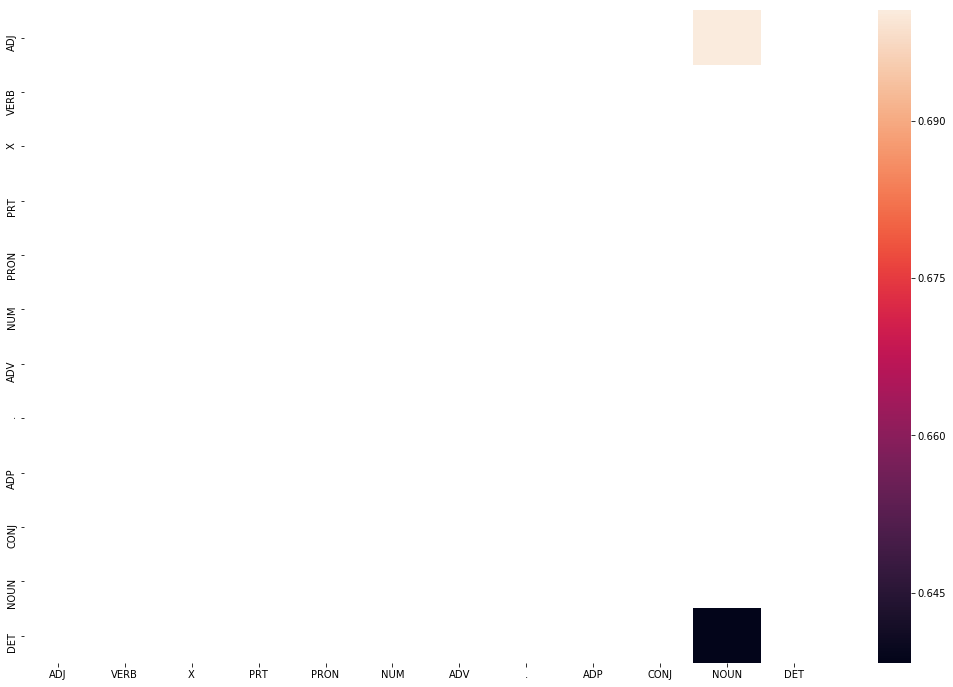

In [15]:
### Understanding frequency of tags
### and filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

Clearly as expected Noun and Adjective and Noun and Determinent are highly correlated. Most often nouns are followed by adjectives and detectives

In [16]:
### Fetching the total length of tagged words in training corpus data
len(train_tagged_words)

95708

In [17]:
### Modified version of Viterbi Heuristic function to solve current problem.
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        ### initialising list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            ### Computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        ### Getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
### Running on entire test dataset would take more than 3-4 hours so better test on sample of data set. 
### Let's test our Viterbi algorithm on a few sample sentences of test dataset

### List of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

### List of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [19]:
### Tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [20]:
### Printing total time taken to train the algorithm to see performance
print(difference)

2175.0269346237183


In [21]:
### Fetching accuracy of build model.
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9198872785829307


We get around 90% of accuracy with the default Viterbi algorithm.

Let's compare with the test sentences and see how it tagged the sentences

In [22]:
### Reading the Test sentence text file
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [23]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [24]:
### Striping the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [25]:
### Fetching the words in the test setting which are incorrectly classified.
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('$', '.'), (('47.5', 'ADJ'), ('47.5', 'NUM'))],
 [('to', 'PRT'), (('end', 'NOUN'), ('end', 'VERB'))],
 [('The', 'DET'), (('Huntsville', 'ADJ'), ('Huntsville', 'NOUN'))],
 [(',', '.'), (('Ala.', 'ADJ'), ('Ala.', 'NOUN'))],
 [('``', '.'), (('Particularly', 'ADJ'), ('Particularly', 'ADV'))],
 [('numerous', 'ADJ'), (('failures', 'ADJ'), ('failures', 'NOUN'))],
 [('to', 'PRT'), (('properly', 'ADJ'), ('properly', 'ADV'))],
 [('properly', 'ADV'), (('record', 'NOUN'), ('record', 'VERB'))],
 [('in', 'ADP'), (('spite', 'ADJ'), ('spite', 'NOUN'))],
 [('the', 'DET'), (('firm', 'NOUN'), ('firm', 'ADJ'))],
 [('to', 'PRT'), (('correct', 'ADJ'), ('correct', 'VERB'))],
 [('of', 'ADP'), (('0.50', 'ADJ'), ('0.50', 'NUM'))],
 [('to', 'PRT'), (('14.00', 'ADJ'), ('14.00', 'NUM'))],
 [('Both', 'DET'), (('Deryck', 'ADJ'), ('Deryck', 'NOUN'))],
 [('who', 'PRON'), (('*T*-256', 'ADJ'), ('*T*-256', 'X'))],
 [('*T*-256', 'X'), (('heads', 'NOUN'), ('heads', 'VERB'))],
 [('S.', 'NOUN'), (('Wadsworth', 'ADJ'), ('W

Most of the words which are not present in training set are simply assigned the first pos tag in the training pos tagset

Let us do the analysis on the test file which we read before

In [27]:
### Getting the predictions on given the test sentences.
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'ADJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADJ'),
 ('.', '.'),
 ('Android', 'ADJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADJ'),
 ('worldwide', 'ADJ'),
 ('on', 'ADP'),
 ('smartphones', 'ADJ'),
 ('since', 'ADP'),
 ('2011', 'ADJ'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADJ'),
 ('.', '.'),
 ('Google', 'ADJ'),
 ('and', 'CONJ'),
 ('Twitter', 'ADJ'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADJ'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADJ'),
 ("'s", 'PRT'),
 ('firehose', 'ADJ'),
 ('.', '.'),
 ('Twitter', 'ADJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

For words like 'Android','Google' the first tag in the training pos tagset is given. Let us see if these words exist in the training corpus 

In [28]:
### Getting the tokens in the test file.
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [29]:
### Getting the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['2018',
 'OS',
 'firehose',
 '2011',
 'Cup',
 'NASA',
 'arriving',
 '21st',
 'online',
 'Google',
 'tweets',
 'invited',
 'FIFA',
 'personality',
 'messages',
 'ICESAT-2',
 'Twitter',
 'trips',
 '2015',
 '2013',
 'domineering',
 'contested',
 'worldwide',
 'Satellite',
 'interact',
 'smartphones',
 'Android',
 'tournament']

Clearly the words like 'Google','Android','Fifa' are not present in the training set and they are all tagged default tags. 

In [30]:
### Getting the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'ADJ'),
 ('Google', 'ADJ'),
 ('Android', 'ADJ'),
 ('OS', 'ADJ'),
 ('worldwide', 'ADJ'),
 ('smartphones', 'ADJ'),
 ('2011', 'ADJ'),
 ('2013', 'ADJ'),
 ('Google', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('2015', 'ADJ'),
 ('Google', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('firehose', 'ADJ'),
 ('Twitter', 'ADJ'),
 ('online', 'ADJ'),
 ('interact', 'ADJ'),
 ('messages', 'ADJ'),
 ('tweets', 'ADJ'),
 ('domineering', 'ADJ'),
 ('personality', 'ADJ'),
 ('2018', 'ADJ'),
 ('FIFA', 'ADJ'),
 ('Cup', 'ADJ'),
 ('21st', 'ADJ'),
 ('FIFA', 'ADJ'),
 ('Cup', 'ADJ'),
 ('tournament', 'ADJ'),
 ('contested', 'ADJ'),
 ('Cup', 'ADJ'),
 ('trips', 'ADJ'),
 ('arriving', 'ADJ'),
 ('NASA', 'ADJ'),
 ('invited', 'ADJ'),
 ('ICESAT-2', 'ADJ'),
 ('Satellite', 'ADJ')]

In [31]:
### Now, Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'ADV': 3014,
         '.': 11103,
         'DET': 8322,
         'ADJ': 6067,
         'NOUN': 27491,
         'ADP': 9352,
         'CONJ': 2151,
         'VERB': 12923,
         'PRT': 3071,
         'X': 6278,
         'PRON': 2602,
         'NUM': 3334})

In [32]:
### See most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27491), ('VERB', 12923), ('.', 11103), ('ADP', 9352), ('DET', 8322)]

In [33]:
### Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADJ': 288,
         'NOUN': 36,
         'DET': 5,
         'ADP': 27,
         'VERB': 19,
         'PRT': 3,
         'ADV': 20})

In [34]:
### Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20691789832082333


[('need', 'VERB'),
 ('imposed', 'VERB'),
 ('codified', 'VERB'),
 ('exhausted', 'VERB'),
 ('limited', 'VERB'),
 ('continued', 'VERB'),
 ('helped', 'VERB'),
 ('exceed', 'VERB'),
 ('based', 'VERB'),
 ('failed', 'VERB'),
 ('acquired', 'VERB'),
 ('restructured', 'VERB'),
 ('improved', 'VERB'),
 ('continued', 'VERB'),
 ('called', 'VERB'),
 ('existed', 'VERB'),
 ('incurred', 'VERB'),
 ('mixed', 'VERB'),
 ('pointed', 'VERB'),
 ('composed', 'VERB')]

Around 20% of words which end with 'ed' are verbs. Though it is 20% it is high because this is universal tagset and Verbs contain all the forms of verbs

In [35]:
### Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10864350383037995


[('including', 'VERB'),
 ('including', 'VERB'),
 ('coming', 'VERB'),
 ('trying', 'VERB'),
 ('bundling', 'VERB'),
 ('targeting', 'VERB'),
 ('looming', 'VERB'),
 ('initialing', 'VERB'),
 ('amending', 'VERB'),
 ('introducing', 'VERB'),
 ('exceeding', 'VERB'),
 ('quitting', 'VERB'),
 ('holding', 'VERB'),
 ('Buying', 'VERB'),
 ('indicating', 'VERB'),
 ('saying', 'VERB'),
 ('coming', 'VERB'),
 ('demanding', 'VERB'),
 ('passing', 'VERB'),
 ('thumbing', 'VERB')]

In [36]:
### Lets see percentage of Adjective tags followed by nouns
### Creating a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

### Creating a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

### Creating a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6067
4250
0.7005109609362123


Around 70% of adjectives are followed by Nouns

In [37]:
### Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8322
5312
0.6383080990146599


Around 63% of determinants are followed by Nouns

In [38]:
### Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3014
1041
0.34538818845388186


Around 35% of adverbs are followed by verbs

Lets use the EDA done above and also grammar to build our rules for regex based tagger

In [39]:
### Specifing the patterns for tagging.
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [40]:
### Rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

### Lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9480676328502415

For a Unigram lexicon tagger backed up by a rule based tagger the accuracy is around 94%. Let us improve it further by using N-gram taggers

#### Evaluating tagging accuracy

In [41]:
#### Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

Let us use Brill algorithm as a base algorithm backed by the tagger created above

In [42]:
### Importing libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

### Clear existing templates if any
Template._cleartemplates()

### Loading the fntbl37 template
templates = fntbl37()
 
### Training the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

The state probabilities for unknown words become zero and hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

Now lets modify the Viterbi algorithm such that when the state probabilities become zero it updates the tag based on the tagger we created above

In [43]:
# Updated Viterbi Heuristic algorithm to solve current work.
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            ### Computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        ### Checking if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            ### Getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [44]:
### tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
### Print total time taken to train the algorithm
print(difference)

1783.3797931671143


In [45]:
### Calculating the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9512882447665056

Accuracy is increased much by the updated Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [46]:
### Let us print the test lines with the initial Viterbi algorithm
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.')]
[('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.')]
[('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.')]
[('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', '

In [47]:
### Let us print the test lines with the updated Viterbi algorithm
for line in test_lines:
    print(list(Viterbi_updated(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

The following sentences are corrected by the modified viterbi algorithm

##### 'Android is a mobile operating system developed by Google.'

Here 'Android', 'Google' are unknown words and are incorrectly tagged in the initial viterbi algorithm. However with the updated Viterbi algorithm 'Android' and 'Google' are correctly classified as Nouns though they are unknown words

###### 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

Here 'Android', 'Google',' worldwide' are unknown words and are incorrectly tagged in the initial viterbi algorithm. However with the updated Viterbi algorithm 'Android' and 'Google' are correctly classified as Nouns though they are unknown words.

Also words like '2011' are incorrectly classified with the original algorithm. Because we used rule based tagger as backoff tagger and we have rule for indicating cardinal numbers '2011' is correctly tagged as 'NUM' in the updated viterbi algorithm

 ##### 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

Here 'NASA', 'ICESAT-2',' Satellite' are unknown words and are incorrectly tagged in the initial viterbi algorithm. However with the updated Viterbi algorithm 'Android' and 'Google' are correctly classified as Nouns though they are unknown words.

Also words like '2011' are incorrectly classified with the original algorithm. Because we used rule based tagger as backoff tagger and we have rule for indicating cardinal numbers '2011' is correctly tagged as 'NUM' in the updated viterbi algorithm

In [48]:
### Again update Viterbi Heuristic to get more accuracy.
def Viterbi_updated2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        ### Initialising list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            ### Computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        ### Checking if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            ### Getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [49]:
### Tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated2(test_tagged_words)
end = time.time()
difference = end-start
### Print total time taken to train the algorithm
print(difference)

1994.6696999073029


In [50]:
### Calculating the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.946658615136876